## GRINN 1D code in Pytorch

GRINN model was implemented using DEEPXDE. https://github.com/sauddy/GRINN/tree/main/PINNs-Hydro-Gravity

This version is the same code but written in Pytorch
Version -- 0.1 this is a 1D code. 

3D code is in preparation


@author: Sayantan 
@date: 9 Feb 2024

In [1]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [2]:
import numpy as np

## TORCH IMPORTS ##
import torch
import torch.nn as nn
from torch.autograd import Variable

import sys
import platform
import matplotlib.pyplot as plt

from numpy.fft  import fft, ifft,fft2, ifft2,fftn, ifftn
from scipy import signal
import os
import scipy
import time

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if torch.backends.mps.is_built() \
    else "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")

# print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Linux-3.10.0-1160.90.1.el7.x86_64-x86_64-with-glibc2.30
PyTorch Version: 2.0.1
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda:0


## Architecture of the the Neural Network

In [3]:
class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)
    
class PINNs(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(PINNs, self).__init__()
   

        layers = []
        for i in range(num_layer-1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
                layers.append(Sin())
                # layers.append(torch.sin(layers))
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(Sin())

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

        self.linear = nn.Sequential(*layers)

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        return self.linear(src)
    

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

## Model INITIALIZATION

In [16]:
net = PINNs(in_dim=2, hidden_dim=32, out_dim=3, num_layer=3).to(device)
net.apply(init_weights) ## This is optional 
print(net) 
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(),lr=0.001,)
optimizerL = torch.optim.LBFGS(net.parameters(),line_search_fn='strong_wolfe')


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Sin()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sin()
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [17]:
######### Boundary Conditions ##########

def get_boundary_rho_vel_phi(x_bc_l,x_bc_r,t,net):

    '''
    Estimate the loss at the boundary
    Input: The collocation points at the boundary
           PINN network/model
           Time domain for the time dependent PDEs
           
    Output:The loss for each of the boudary values    
    '''
    
  
    rho_l, vel_l, phi_l = net(x_bc_l,t)[:,0:1], net(x_bc_l,t)[:,1:2], net(x_bc_l,t)[:,2:3]   
    rho_r, vel_r, phi_r = net(x_bc_r,t)[:,0:1], net(x_bc_r,t)[:,1:2], net(x_bc_r,t)[:,2:3]


    phi_l_x = torch.autograd.grad(phi_l, x_bc_l,grad_outputs=torch.ones_like(phi_l), create_graph=True)[0]
    phi_r_x = torch.autograd.grad(phi_r, x_bc_r,grad_outputs=torch.ones_like(phi_r), create_graph=True)[0]


    rho_b    = rho_l - rho_r
    v_b      = vel_l - vel_r
    phi_b    = phi_l - phi_r
    phi_x_b  = phi_l_x - phi_r_x


    return rho_b, v_b, phi_b , phi_x_b
    
    



######### Residue from the PDEs##########

def pde_residue(x,t,net):
    
    '''
    This is the main function that returns all the PDE residue
    INPUT: x and t collocation points for the 1D problem
    OUTPUT: The output dimension is 3, one of density, one for velocity and finally for phi
    '''
    
    net_outputs = net(x,t)
    
    rho, v, phi = net_outputs[:,0:1], net_outputs[:,1:2], net_outputs[:,2:3]
    
    ## Derivatives for the Equations:
    rho_x = torch.autograd.grad(rho, x,grad_outputs=torch.ones_like(rho), create_graph=True)[0]
    rho_t = torch.autograd.grad(rho, t,grad_outputs=torch.ones_like(rho),create_graph=True)[0]
    
    v_x = torch.autograd.grad(v, x,grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t,grad_outputs=torch.ones_like(v), create_graph=True)[0]
    
    phi_x = torch.autograd.grad(phi, x,grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_x_x = torch.autograd.grad(phi_x, x,grad_outputs=torch.ones_like(phi_x), create_graph=True)[0]
    
    ## The residues from the equations
    rho_r = rho_t + v * rho_x + rho * v_x
    v_r = rho_t*v +rho*v_t + rho_x*v*v + rho*v_x*v + rho*v*v_x  + cs*cs*rho_x + rho*phi_x    
    phi_r = phi_x_x - const*(rho - rho_o)
    
    return rho_r,v_r,phi_r



## Setting up the problem

### CASE 1: Linear perturbation with gravity for $\lambda = 1.11 \lambda_{\rm J}$
### CASE 2: NonLinear perturbation with gravity for $\lambda = 1.11 \lambda_{\rm J}$
### CASE 3: Linear perturbation with gravity for $\lambda < \lambda_{\rm J}$

In [18]:
## CASE 1           (refer to the paper for details)
lam = 7.0           # one wavelength
num_of_waves = 2
rho_1 = 0.03        # question 2a linear wave propagation

# ## CASE 2          (refer to the paper for details)
# lam = 7.0          # one wavelength
# num_of_waves = 3
# rho_1 = 0.3        # question 2a linear wave propagation

# ## CASE 2          (refer to the paper for details)
# lam = 5.0          # one wavelength
# num_of_waves = 3
# rho_1 = 0.03       # question 2a linear wave propagation


In [19]:
### PROBLEM CONSTANTS ####
rho_o = 1          ## zeroth order density
cs = 1.0           ##  Sound Speed
const = 1          ## we set 4 pi G  to 1
G = 1

output_folder = "1D_fig" 
os.makedirs(output_folder, exist_ok=True)


    
################ THE ANALYTIC MODEL ####################
  

jeans = np.sqrt(4*np.pi**2*cs**2/(const*G*rho_o))

if lam> jeans:
    alpha = np.sqrt(const*G*rho_o-cs**2*(2*np.pi/lam)**2)
else:
    alpha = np.sqrt(cs**2*(2*np.pi/lam)**2 - const*G*rho_o)
    
# v_1 = (cs*rho_1)/rho_o                     ## velocity perturbation without gravity
v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity


def fun_rho_0(x):
    ''' Define initial condition for density Returning Eq (11a)'''
    print('wavelength',lam)
    rho_0 = rho_o + rho_1 * np.cos(2*np.pi*x/lam)    
    return rho_0

def fun_v_0(x):
    '''initial condition for velocity -- Returning Eq 11b'''
    
    if lam > jeans:
        v_0 = - v_1 * np.sin(2*np.pi*x/lam)## This is for sound wave ## refer to the paper for details
    else:
        v_0 = v_1 * np.cos(2*np.pi*x/lam)  ## This is for the gravity wave
    return v_0
    


### Setup the DOMAIN

In [20]:
## TIME & SPACE
tmin = 0.
tmax = 1.

xmin = 0.
xmax = xmin+lam*num_of_waves

cs = 1.

### NUMBER OF COLLOCATION POINTS ##

N_0 = 10000   ## for IC
N_b = 10000   ## for BC
N_r = 30000  ## for Domain



############## IC setup ################

# Intial conditions collocation points
x_0 = np.random.uniform(low=xmin, high=xmax, size=(N_0,1))
t_0 = np.zeros((N_0,1))

# Evaluate intitial condition at x_0
rho_0 = fun_rho_0(x_0)
v_0 = fun_v_0(x_0)

#IC torch variable
pt_x_0 = Variable(torch.from_numpy(x_0).float(), requires_grad=False).to(device)
pt_t_0 = Variable(torch.from_numpy(t_0).float(), requires_grad=False).to(device)
pt_rho_0 = Variable(torch.from_numpy(rho_0 ).float(), requires_grad=False).to(device)
pt_vel_0 = Variable(torch.from_numpy(v_0).float(), requires_grad=False).to(device)

# ## Checking the initial profiles
# plt.scatter(x_0, rho_0,s=20, c='b', marker='o',label="Ini-Density")
# plt.scatter(x_0, v_0,s=2, c='r', marker='*',label="Ini-Velocity" )
# plt.legend()



############## BC setup ################

x_bc_l = np.empty(N_b); x_bc_l.fill(xmin)
x_bc_r = np.empty(N_b); x_bc_r.fill(xmax)
t_bc = np.random.uniform(low=tmin, high=tmax, size=(N_b,1))
#BC torch variable
pt_x_bc_l = Variable(torch.from_numpy(x_bc_l.reshape(N_b,1)).float(), requires_grad=True).to(device)
pt_x_bc_r = Variable(torch.from_numpy(x_bc_r.reshape(N_b,1)).float(), requires_grad=True).to(device)
pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)


############## PDE setup ################


x_collocation = np.random.uniform(low=xmin, high=xmax, size=(N_r,1))
t_collocation = np.random.uniform(low=tmin, high=tmax, size=(N_r,1))

#as torch variable
pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
print(np.shape(pt_x_collocation))


wavelength 7.0
torch.Size([30000, 1])


In [21]:
# net_ic_out = net(pt_x_0, pt_t_0) 
# print(net_ic_out)
# print(np.shape(net_ic_out))
# rho_ic_out = net_ic_out[:,0:1]
# print(np.shape(rho_ic_out))

In [22]:
from tqdm import tqdm
import time
iterations = 200
start = time.time()
def closure():

        ############## Loss based on initial conditions ###############

        net_ic_out = net(pt_x_0, pt_t_0) # output of rho(x,t=0), vel(x,t=0)

        rho_ic_out = net_ic_out[:,0:1]
        vel_ic_out = net_ic_out[:,1:2]

        mse_rho_ic =  mse_cost_function(rho_ic_out, pt_rho_0)
        mse_vel_ic =  mse_cost_function(vel_ic_out, pt_vel_0)

        ############# Loss based on boundary conditions #################

        rho_b, v_b, phi_b, phi_x_b = get_boundary_rho_vel_phi(pt_x_bc_l,pt_x_bc_r,pt_t_bc,net) # output of u(x,t)


        mse_bc_rho = torch.mean(rho_b ** 2) ## mse_cost_function(rho_bc_out,pt_all_zeros_bc)
        mse_bc_vel = torch.mean(v_b ** 2) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)
        mse_bc_phi = torch.mean(phi_b ** 2) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)
        mse_bc_phi_x = torch.mean(phi_x_b ** 2) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)

        ############## Loss based on PDE ###################################

        rho_r,v_r,phi_r = pde_residue(pt_x_collocation, pt_t_collocation, net) # output of rho(x,t) and vel(x,t)


        mse_rho = torch.mean(rho_r ** 2)  ##mse_cost_function(rho_pde_out, pt_all_zeros)
        mse_vel = torch.mean(v_r ** 2)  ## mse_cost_function(vel_pde_out, pt_all_zeros)
        mse_phi = torch.mean(phi_r ** 2)  ## mse_cost_function(vel_pde_out, pt_all_zeros)

        ################### Combining the loss functions ####################
        loss = mse_rho_ic + mse_vel_ic + mse_rho + mse_vel + mse_phi+ mse_bc_rho+ mse_bc_vel + mse_bc_phi+ mse_bc_phi_x
        optimizerL.zero_grad()
        loss.backward() # This is for computing gradients using backward propagationerivative of J w.r.t theta
        return loss
TOTAL_loss = []

## Using ADAM 

for i in tqdm(range(iterations)): 
    loss_ = optimizer.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
print("INFO:Adam training done LBFGS initiated")       
## Using LBFGS after the initial ADAM training
for i in tqdm(range(iterations)): 
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

  4%|▍         | 8/200 [00:00<00:04, 40.25it/s]

TOTAL LOSS =5.54e+00


 31%|███       | 62/200 [00:01<00:02, 57.36it/s]

TOTAL LOSS =1.15e-01


 55%|█████▌    | 110/200 [00:01<00:01, 57.53it/s]

TOTAL LOSS =2.57e-02


 79%|███████▉  | 158/200 [00:02<00:00, 57.76it/s]

TOTAL LOSS =8.91e-03


  0%|          | 1/200 [00:00<01:22,  2.40it/s]

TOTAL LOSS =5.89e-03


 26%|██▌       | 51/200 [00:30<01:22,  1.81it/s]

TOTAL LOSS =4.79e-06


 52%|█████▏    | 104/200 [00:36<00:02, 32.09it/s]

TOTAL LOSS =3.98e-06


 78%|███████▊  | 156/200 [00:37<00:01, 34.14it/s]

TOTAL LOSS =3.98e-06


100%|██████████| 200/200 [00:39<00:00,  5.11it/s]

Total time = 42.71825861930847 sec 


Plotting at t= 0.0
rho_theory_max=1.03 at time 0.0
Plotting at t= 0.3333333333333333
rho_theory_max=1.0347484778920246 at time 0.3333333333333333
Plotting at t= 0.6666666666666666
rho_theory_max=1.0402485571937508 at time 0.6666666666666666
Plotting at t= 1.0
rho_theory_max=1.0466192033277646 at time 1.0


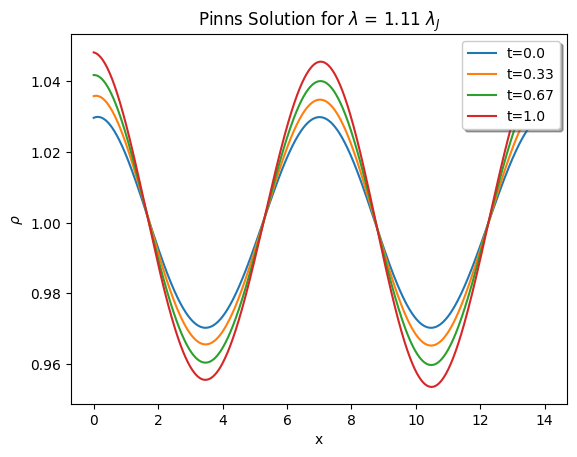

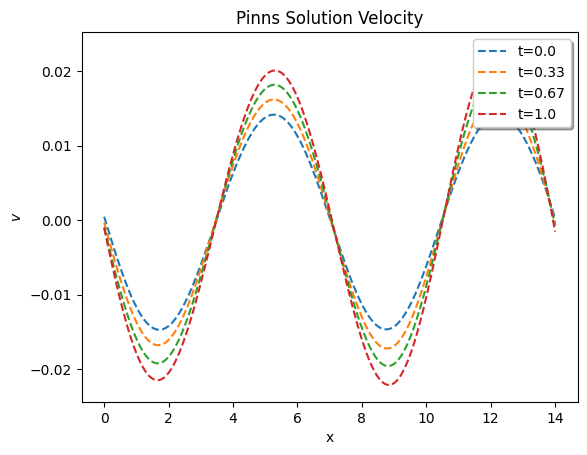

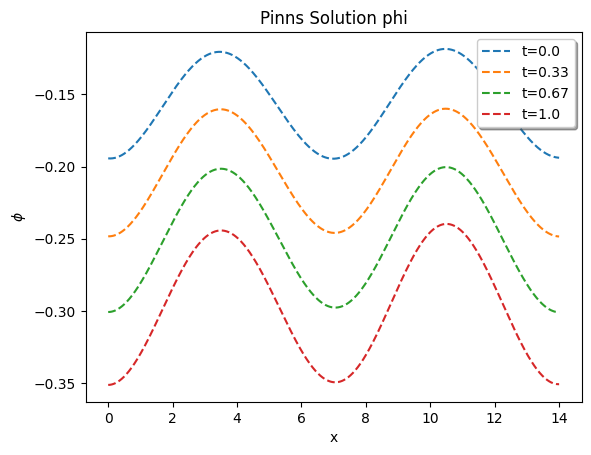

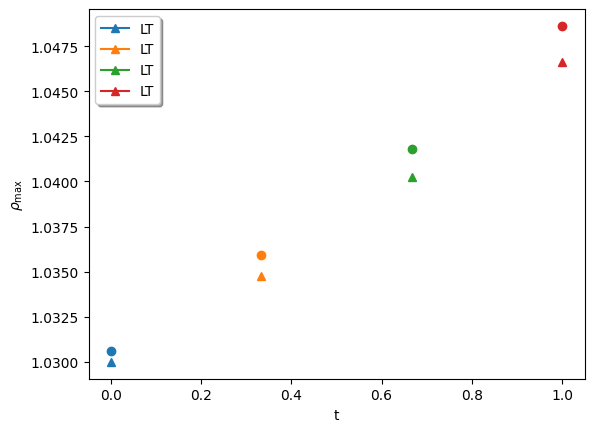

In [ ]:
import Plotting_1D as pt
time_array = np.linspace(0,int(tmax),int(tmax)+3)
initial_params = xmin,xmax,rho_1, alpha ,lam ,output_folder,tmax ## required for plotting
pt.plot_function(net,time_array,initial_params,velocity=True,isplot =True)

In [ ]:
import LAX as LAX
import numpy as np

## Parameters for the LAX method    
nu = 0.5            # COURANT number
N = 1000            # number of grid points

import time

# start = time.time()
# # t = 1          # time till integrate
# # LAX.lax_solution1D(t,N,nu,lam,num_of_waves,rho_1,gravity=True,isplot = True,comparison = True)
# end = time.time()
# print("Total time = {} sec for N= {}".format(end - start,N))


time_array = np.asarray([0.5,1.5,tmax])
for time_ in time_array:
    LAX.lax_solution1D(time_,N,nu,lam,num_of_waves,rho_1,gravity=True,isplot = True,comparison = True,animation=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

at time=  0.5
For dx = 0.014 and dt = 0.007 and time gridpoints n = 71 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 0.5
at time=  0.5
For dx = 0.014 and dt = 0.007 and time gridpoints n = 71 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 0.5
at time=  1.0
For dx = 0.014 and dt = 0.007 and time gridpoints n = 142 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
Plotting at t= 1.0


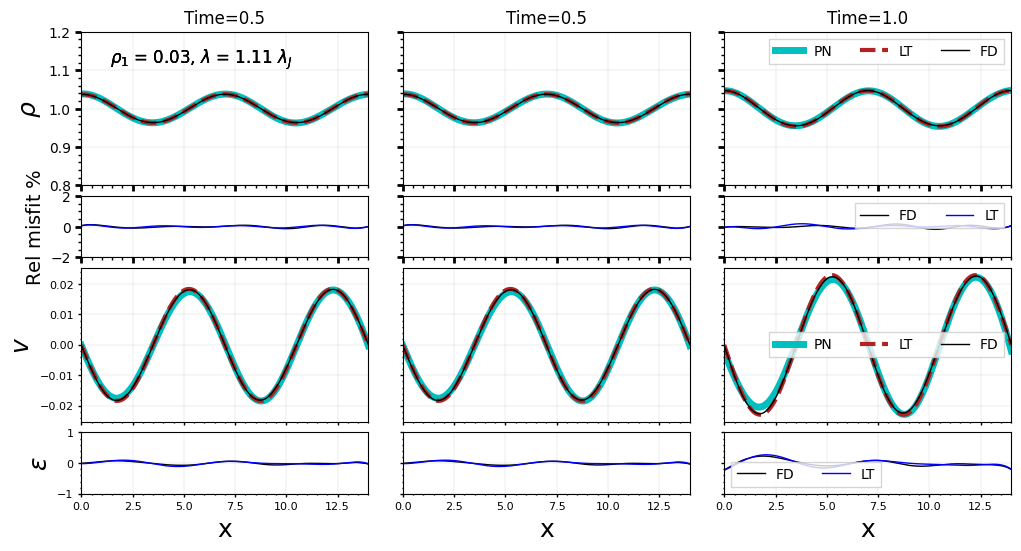

In [15]:
plt.style.use('default')
plt.rc('grid', linestyle='-', color='black', linewidth=0.05)
time_array = np.asarray([0.5,tmax-0.5,tmax])
fig, axes = plt.subplots(4, 3, sharex=True,  sharey='row',figsize=(12,6),gridspec_kw={'width_ratios':[1,1,1], 'height_ratios':[3,1.2,3,1.2]})
plt.subplots_adjust(wspace=0.12, hspace=0.1)
initial_params = xmin,xmax,rho_1, alpha ,lam ,output_folder,tmax ## Params for pl
for time,j in zip(time_array,range(3)):
    
    x,rho,v,phi,n,rho_LT,rho_LT_max,rho_max,v_LT= LAX.lax_solution1D(time,N,nu,lam,num_of_waves,rho_1,gravity=True,isplot = False,comparison = True)
    X,rho_pred0,v_pred0,phi_pred0,rho_max_PN,rho_theory = pt.plot_function(net,time,initial_params,velocity=True,isplot = False, animation=True)
    axes[0][j].plot(X,rho_pred0,color='c',linewidth=5,label="PN")    
    axes[0][j].plot(x,rho_LT,linestyle='dashed',color ='firebrick',linewidth=3,label="LT")
    axes[0][j].plot(x,rho,linestyle='solid',color = 'black',linewidth=1.0,label="FD")
    axes[0][j].set_xlim(xmin,xmax)
    
    axes[0][j].set_title("Time={}".format(round(time,2)))
    axes[0][0].set_ylabel(r"$\rho$",fontsize = 18)
    # axes[0][j].set_xlabel("x",fontsize = 18)
    axes[0][j].grid("True")
    axes[0][j].minorticks_on()
    axes[0][j].tick_params(labelsize=10)
    axes[0][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[0][j].tick_params(axis='both', which='minor',length=2, width=1)
    limu = 1.2*rho_o
    liml = .8*rho_o
    axes[0][j].set_ylim(liml,limu)
    axes[0][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    axes[0][0].text(0.42, 0.82, r"$\rho_1$ = {}, $\lambda$ = {} $\lambda_J$ ".format(rho_1,round(lam/(2*np.pi),2)),fontsize = 12, horizontalalignment='center', verticalalignment='center', transform=axes[0][0].transAxes) 

    
    axes[1][j].plot(X,(rho_pred0[:,0]- rho)/((rho_pred0[:,0]+ rho)/2)*100,color = 'black',linewidth=1,label="FD")
    # axes[1][j].plot(x,(rho_pred0.flatten()-rho_LT.flatten())/((rho_pred0.flatten()+ rho_LT.flatten())/2)*100,color = 'firebrick',linestyle='dashed',linewidth=1,label="LT")
    # axes[1][j].plot(x,(rho_pred0[:,0]- rho[n-1,:])/((rho_pred0[:,0]+ rho[n-1,:])/2)*100,color = 'k',linewidth=1,label="FD")
    axes[1][j].plot(X,(rho_pred0[:,0]-rho_LT)/((rho_pred0[:,0]+ rho_LT)/2)*100,color = 'b',linewidth=1,label="LT")
    axes[1][j].set_xlabel("x",fontsize = 18)
    axes[1][j].grid("True")
    axes[1][j].minorticks_on()
    axes[1][j].tick_params(labelsize=10)
    axes[1][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[1][j].tick_params(axis='both', which='minor',length=2, width=1.)
    axes[1][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    # axes[1][0].set_ylabel(r"$\rho_{PN}- \rho_{FD or LT}/(0.5 (\times\rho_{PN}+ \rho_{FD or LT}))$",fontsize = 10)
    axes[1][j].set_ylim(-2.0,2.0)
    axes[1][j].set_xlim(xmin,xmax)
    axes[1][0].set_ylabel(r"Rel misfit $\%$ ",fontsize = 14)
    
    
    ### VELOCITY PART ######
   
    axes[2][j].plot(X,v_pred0,color='c',linewidth=5,label="PN")    
    axes[2][j].plot(X,v_LT,linestyle='dashed',color ='firebrick',linewidth=3,label="LT")
    axes[2][j].plot(x,v,linestyle='solid',color = 'black',linewidth=1.0,label="FD")
    
    
    # axes[3][j].set_title("Time={}".format(round(time,2)))
    axes[2][0].set_ylabel(r"$v$",fontsize = 18)
    # axes[0][j].set_xlabel("x",fontsize = 18)
    axes[2][j].grid("True")
    axes[2][j].minorticks_on()
    axes[2][j].tick_params(labelsize=8)
    axes[2][j].tick_params(axis='both', which='major',length=2, width=1)
    axes[2][j].tick_params(axis='both', which='minor',length=1, width=1)
    # limu = 1.15*v_o
    # liml = .85*v_o
    # axes[0][j].set_ylim(liml,limu)
    axes[2][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    
#     axes[2][j].set_xlim(xmin,xmax)
#     axes[2][j].set_ylim(-0.6,0.6)
    
    
    axes[3][j].plot(x,(v_pred0[:,0]+1- (v+1))/((v_pred0[:,0]+1+ v+1)/2)*100,color = 'black',linewidth=1,label="FD")
    axes[3][j].plot(x,(v_pred0[:,0]+1- (v_LT+1))/((v_pred0[:,0]+1+ (v_LT+1))/2)*100,color = 'b',linewidth=1,label="LT")
    axes[3][j].set_xlabel("x",fontsize = 18)
    axes[3][j].grid("True")
    axes[3][j].minorticks_on()
    axes[3][j].tick_params(labelsize=8)
    axes[3][j].tick_params(axis='both', which='major',length=2, width=1)
    axes[3][j].tick_params(axis='both', which='minor',length=1, width=1.)
    axes[3][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    # axes[1][0].set_ylabel(r"$\rho_{PN}- \rho_{FD or LT}/(0.5 (\times\rho_{PN}+ \rho_{FD or LT}))$",fontsize = 10)
    axes[3][0].set_ylabel(r"$\epsilon$ ",fontsize = 18)
    axes[3][j].set_ylim(-1,1)
    axes[3][j].set_xlim(xmin,xmax)
    
    
plt.savefig(output_folder+'/complete'+str(lam)+'_'+str(num_of_waves)+'_'+str(tmax)+'.png', dpi=500,bbox_inches = 'tight')

# plt.show()
 